## Blocket Car in pySpark

### Jonas Lundgren  
### Last Updated: Jan 26, 2019

---  

### Sources 

https://www.youtube.com/watch?v=XQgXKtPSzUI&t=0s&index=2&list=LLgrRgAlce_d0J02aHPrp4nA

University of California, Santa Barbara: PSTAT 135/235, winter quarter 2019

### Explanation
- Part 1: Webscraping of cars for sale in Skåne, Sweden from private sellers. Scraping is done from Swedish buy and sell site https://www.blocket.se/ using BeautifulSoup.
- Part 2: Data preprocessing done using pySpark since I wanted to practice and was not necessary for a data set containing about 2500 rows (scraping done on Jan 26 2019). Visualizations are done using pandas and matplotlib.
- Part 3: Continuing with cleaning data and feature engineering. (new scraping done on Feb 02 2019)


#### Note: 
Formating of the webpage where the scraping was done could change if this is read at a later time.

---  

### Part 1 
#### Jan 26, 2019
Loading packages used for webscraping.

In [1]:
import requests
from bs4 import BeautifulSoup

Url to the site where scraping will be done.

In [2]:
my_url = 'https://www.blocket.se/malmo/bilar?ca=23_11&cg=1020&st=s&l=0&f=p&w=1'
client = requests.get(my_url).text

In [3]:
soup = BeautifulSoup(client, "html.parser")

The path in the html file we are interested in.

In [4]:
cars = soup.find_all('div', {'id': 'item_list'})[0].find_all('article')

Testing to scrape data from the second car on blocket to see if everything is ok

In [5]:
info = cars[1]
location = info.div.div.text
date = info.div.time.get('datetime')
title = info.div.find('a', {'class': 'item_link'}).text.replace(',', '|')

splited_info = info.div.p.text.split(' | ')

fuel = splited_info[0]
gear = splited_info[1]
dist = splited_info[2]
price = info.div.find('p', {'class' : 'list_price font-large'}).text



Testing to loop over all cars on the first page of cars in the wanted region. If the # signs are removed a file called "blocket_cars.csv" is stored containing the cars at the first page.

In [6]:
filename = "blocket_cars.csv"
#f = open(filename, "w")
headers = "date, title, dist, price, fuel, gear, location\n"
#f.write(headers)

for car in cars:
    info = car
   
    date = info.div.time.get('datetime')
    title = info.div.find('a', {'class': 'item_link'}).text.replace(',', '|')

    splited_info = info.div.p.text.split(' | ')

    fuel = splited_info[0]
    gear = splited_info[1]
    dist = splited_info[2]
    price = info.div.find('p', {'class' : 'list_price font-large'}).text
    location = info.div.div.text

    #f.write(date + "," + title + "," + dist + "," + price + "," + fuel + "," + gear + "," + location + "\n")
    
#f.close()

Here a file called "blocket_cars.csv" is created containing all cars in Skåne not from resellers is stored. The while loop loops over all pages on blocket with the search results we are interested in. At current time it was 52 pages. For every page we loop over the number of cars and store the data we are interseted in: date, title, dist, price, fuel, gear, location. The page number is printed to see how far the scraping process has passed. 

In [7]:
filename = "blocket_cars.csv"
f = open(filename, "w")
headers = "date, title, dist, price, fuel, gear, location\n"
f.write(headers)
stop = 'NA'
i = 1

while(stop != 'Inga träffar i Bilar'):
    
    my_url = 'https://www.blocket.se/malmo/bilar?ca=23_11&cg=1020&st=s&l=0&f=p&w=1&o=' + str(i)

    client = requests.get(my_url).text

    soup = BeautifulSoup(client, "html.parser")
    
    try:
        stop = soup.find_all('div', {'class': 'ads_not_found col-xs-12'})[0].h3.text
    except:
        print('Page number: ' + str(i))
    
    cars = soup.find_all('div', {'id': 'item_list'})[0].find_all('article')
    
    for car in cars:
        info = car
        
        if(info.div.p.text == ''):
            break
        
        date = info.div.time.get('datetime')
        title = info.div.find('a', {'class': 'item_link'}).text.replace(',', '|')

        splited_info = info.div.p.text.split(' | ')
        
        fuel = splited_info[0]
        gear = splited_info[1]
        dist = splited_info[2]
        price = info.div.find('p', {'class' : 'list_price font-large'}).text
        location = info.div.div.text

        f.write(date + "," + title + "," + dist + "," + price + "," + fuel + "," + gear + "," + location + "\n")
    
    i = i+1
    
f.close()

Page number: 1
Page number: 2
Page number: 3
Page number: 4
Page number: 5
Page number: 6
Page number: 7
Page number: 8
Page number: 9
Page number: 10
Page number: 11
Page number: 12
Page number: 13
Page number: 14
Page number: 15
Page number: 16
Page number: 17
Page number: 18
Page number: 19
Page number: 20
Page number: 21
Page number: 22
Page number: 23
Page number: 24
Page number: 25
Page number: 26
Page number: 27
Page number: 28
Page number: 29
Page number: 30
Page number: 31
Page number: 32
Page number: 33
Page number: 34
Page number: 35
Page number: 36
Page number: 37
Page number: 38
Page number: 39
Page number: 40
Page number: 41
Page number: 42
Page number: 43
Page number: 44
Page number: 45
Page number: 46
Page number: 47
Page number: 48
Page number: 49
Page number: 50
Page number: 51
Page number: 52
Page number: 53


### Part 2

SparkSession is imported aswell as other spark packages

In [58]:
from pyspark.sql import SparkSession
import pyspark.sql.types as typ
from pyspark.sql.functions import *
from pyspark.sql import SQLContext
import pandas

spark = SparkSession \
    .builder \
    .master("local") \
    .appName("review_and_category_analytics") \
    .config("spark.executor.memory", '2g') \
    .config('spark.executor.cores', '2') \
    .config('spark.cores.max', '2') \
    .config("spark.driver.memory",'2g') \
    .getOrCreate()

sc = spark.sparkContext
sqlCtx = SQLContext(sc)

The data is read into a data frame called df.

In [4]:
df = spark.read.format("csv")\
    .option("header", "true")\
    .option("ignoreLeadingWhiteSpace",'true')\
    .load("blocket_cars2019-03-21.csv")

The data frame df is saved.

In [5]:
df.cache()

DataFrame[date: string, title: string, dist: string, price: string, fuel: string, gear: string, location: string]

First 5 rows are displayed

In [6]:
df.show(5)

+-------------------+--------------------+-------------------+----------+------+-------+-----------+
|               date|               title|               dist|     price|  fuel|   gear|   location|
+-------------------+--------------------+-------------------+----------+------+-------+-----------+
|2019-03-21 21:46:37|Cadillac Deville ...|  3 500 - 3 999 mil|229 000 kr|Bensin|Automat|      Ystad|
|2019-03-21 21:46:15| Peugeot 206 1.4 -05|10 500 - 10 999 mil| 26 000 kr|Bensin|Manuell|       Höör|
|2019-03-21 21:45:55|   Audi A3 1|6 L -05|23 000 - 23 499 mil| 29 000 kr|Bensin|Manuell|    Sydväst|
|2019-03-21 21:45:26|Seat Ateca TSi 15...|  2 500 - 2 999 mil|225 000 kr|Bensin|Automat|Helsingborg|
|2019-03-21 21:44:52| Volvo xc70 2.5T -05|27 000 - 27 499 mil| 28 000 kr|Bensin|Manuell|      Sjöbo|
+-------------------+--------------------+-------------------+----------+------+-------+-----------+
only showing top 5 rows



In [7]:
df.columns

['date', 'title', 'dist', 'price', 'fuel', 'gear', 'location']

In [8]:
df.printSchema()

root
 |-- date: string (nullable = true)
 |-- title: string (nullable = true)
 |-- dist: string (nullable = true)
 |-- price: string (nullable = true)
 |-- fuel: string (nullable = true)
 |-- gear: string (nullable = true)
 |-- location: string (nullable = true)



Lower casing all caps in the the title.

In [9]:
df = df.withColumn('title', lower(df.title))

Removing the currency sign kr and the space in the price.

In [10]:
df = df\
        .withColumn('price', regexp_replace('price', ' kr', ''))\
        .withColumn('price', regexp_replace('price', ' ', ''))

Convering the price to int.

In [11]:
df = df.withColumn('price', df['price'].cast("int"))

Checking the results

In [12]:
df.show(5)

+-------------------+--------------------+-------------------+------+------+-------+-----------+
|               date|               title|               dist| price|  fuel|   gear|   location|
+-------------------+--------------------+-------------------+------+------+-------+-----------+
|2019-03-21 21:46:37|cadillac deville ...|  3 500 - 3 999 mil|229000|Bensin|Automat|      Ystad|
|2019-03-21 21:46:15| peugeot 206 1.4 -05|10 500 - 10 999 mil| 26000|Bensin|Manuell|       Höör|
|2019-03-21 21:45:55|   audi a3 1|6 l -05|23 000 - 23 499 mil| 29000|Bensin|Manuell|    Sydväst|
|2019-03-21 21:45:26|seat ateca tsi 15...|  2 500 - 2 999 mil|225000|Bensin|Automat|Helsingborg|
|2019-03-21 21:44:52| volvo xc70 2.5t -05|27 000 - 27 499 mil| 28000|Bensin|Manuell|      Sjöbo|
+-------------------+--------------------+-------------------+------+------+-------+-----------+
only showing top 5 rows



Removing mil from the distance the car has traveled.

In [13]:
df = df.withColumn('dist', regexp_replace('dist', ' mil', ''))

Creating a split in the distance the car has traveled.

In [14]:
split_col = split(df['dist'], ' - ')

Creating 2 columns with distance range.

In [15]:
df = df.withColumn('from', split_col.getItem(0))
df = df.withColumn('to', split_col.getItem(1))

Converingt the distance to ints.

In [16]:
df = df.withColumn('from', regexp_replace('from', ' ', ''))
df = df.withColumn('from', df['from'].cast("int"))

df = df.withColumn('to', regexp_replace('to', ' ', ''))
df = df.withColumn('to', df['to'].cast("int"))

In [17]:
df.show(5)

+-------------------+--------------------+---------------+------+------+-------+-----------+-----+-----+
|               date|               title|           dist| price|  fuel|   gear|   location| from|   to|
+-------------------+--------------------+---------------+------+------+-------+-----------+-----+-----+
|2019-03-21 21:46:37|cadillac deville ...|  3 500 - 3 999|229000|Bensin|Automat|      Ystad| 3500| 3999|
|2019-03-21 21:46:15| peugeot 206 1.4 -05|10 500 - 10 999| 26000|Bensin|Manuell|       Höör|10500|10999|
|2019-03-21 21:45:55|   audi a3 1|6 l -05|23 000 - 23 499| 29000|Bensin|Manuell|    Sydväst|23000|23499|
|2019-03-21 21:45:26|seat ateca tsi 15...|  2 500 - 2 999|225000|Bensin|Automat|Helsingborg| 2500| 2999|
|2019-03-21 21:44:52| volvo xc70 2.5t -05|27 000 - 27 499| 28000|Bensin|Manuell|      Sjöbo|27000|27499|
+-------------------+--------------------+---------------+------+------+-------+-----------+-----+-----+
only showing top 5 rows



Splitting the title to get the brand and model of car. The split is done in a sloppy way and there are several cars where the title was not on form: brand model ... This problem is ignored for now.

In [18]:
split_col = split(df['title'], ' ')

In [19]:
df = df.withColumn('brand', split_col.getItem(0))
df = df.withColumn('model', split_col.getItem(1))

In [20]:
df.show(5)

+-------------------+--------------------+---------------+------+------+-------+-----------+-----+-----+--------+-------+
|               date|               title|           dist| price|  fuel|   gear|   location| from|   to|   brand|  model|
+-------------------+--------------------+---------------+------+------+-------+-----------+-----+-----+--------+-------+
|2019-03-21 21:46:37|cadillac deville ...|  3 500 - 3 999|229000|Bensin|Automat|      Ystad| 3500| 3999|cadillac|deville|
|2019-03-21 21:46:15| peugeot 206 1.4 -05|10 500 - 10 999| 26000|Bensin|Manuell|       Höör|10500|10999| peugeot|    206|
|2019-03-21 21:45:55|   audi a3 1|6 l -05|23 000 - 23 499| 29000|Bensin|Manuell|    Sydväst|23000|23499|    audi|     a3|
|2019-03-21 21:45:26|seat ateca tsi 15...|  2 500 - 2 999|225000|Bensin|Automat|Helsingborg| 2500| 2999|    seat|  ateca|
|2019-03-21 21:44:52| volvo xc70 2.5t -05|27 000 - 27 499| 28000|Bensin|Manuell|      Sjöbo|27000|27499|   volvo|   xc70|
+-------------------+---

A new data frame called volvo is created with only the cars of the brand Volvo.

In [21]:
volvo = df.filter(df.brand == 'volvo')
volvo.show(10)

+-------------------+--------------------+---------------+------+------+-------+------------+-----+-----+-----+-----+
|               date|               title|           dist| price|  fuel|   gear|    location| from|   to|brand|model|
+-------------------+--------------------+---------------+------+------+-------+------------+-----+-----+-----+-----+
|2019-03-21 21:44:52| volvo xc70 2.5t -05|27 000 - 27 499| 28000|Bensin|Manuell|       Sjöbo|27000|27499|volvo| xc70|
|2019-03-21 20:36:07|volvo v90 d5 r-de...|  4 000 - 4 499|425000|Diesel|Automat|        Osby| 4000| 4499|volvo|  v90|
|2019-03-21 19:45:07|volvo xc70 d4 mom...|  9 000 - 9 499|189900|Diesel|Automat|       Öster| 9000| 9499|volvo| xc70|
|2019-03-21 18:21:58|volvo v50 t5 awd -04|16 000 - 16 499| 47000|Bensin|Manuell|  Simrishamn|16000|16499|volvo|  v50|
|2019-03-21 17:44:41|volvo v70 2|4 d5 -10|20 000 - 20 499| 81000|Diesel|Automat|Kristianstad|20000|20499|volvo|  v70|
|2019-03-21 16:38:09|    volvo s70 98 -98|22 000 - 22 49

The volvo data frame is converted into a pandas data frame.

In [22]:
volvo_pandas = volvo.toPandas()

A new column is added with the name model_num where each model is asigned a number used for coloring of plot.

In [23]:
volvo_pandas['model_num'] = pandas.factorize(volvo_pandas['model'])[0]

In [24]:
volvo_pandas.head(5)

,date,title,dist,price,fuel,gear,location,from,to,brand,model,model_num
0,2019-03-21 21:44:52,volvo xc70 2.5t -05,27 000 - 27 499,28000.0,Bensin,Manuell,Sjöbo,27000.0,27499.0,volvo,xc70,0
1,2019-03-21 20:36:07,volvo v90 d5 r-design polestar b&w -17,4 000 - 4 499,425000.0,Diesel,Automat,Osby,4000.0,4499.0,volvo,v90,1
2,2019-03-21 19:45:07,volvo xc70 d4 momentum -14,9 000 - 9 499,189900.0,Diesel,Automat,Öster,9000.0,9499.0,volvo,xc70,0
3,2019-03-21 18:21:58,volvo v50 t5 awd -04,16 000 - 16 499,47000.0,Bensin,Manuell,Simrishamn,16000.0,16499.0,volvo,v50,2
4,2019-03-21 17:44:41,volvo v70 2|4 d5 -10,20 000 - 20 499,81000.0,Diesel,Automat,Kristianstad,20000.0,20499.0,volvo,v70,3


Librarys for polting is imported.

In [25]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.polynomial.polynomial import polyfit

A plot of all Volvo cars in the data set are displayed colored based on brand.

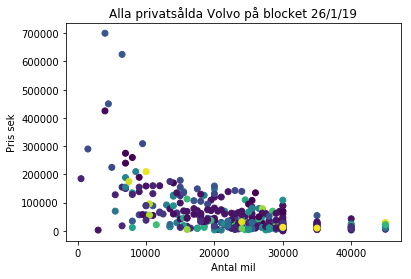

In [26]:
fig, ax = plt.subplots()
scatter = ax.scatter(x = 'from', y = 'price', c = 'model_num', data = volvo_pandas, cmap = 'viridis')
plt.xlabel('Antal mil')
plt.ylabel('Pris sek')
plt.title('Alla privatsålda Volvo på blocket 26/1/19')
plt.show()

A data frame subset containing only the model v70 is stored as v70.

In [27]:
v70 = volvo_pandas[volvo_pandas.model == 'v70']

Removing cars without price and the distance traveled from the data set.

In [28]:
v70 = v70[v70['from'].notnull()]
v70 = v70[v70['price'].notnull()]

A regression line is derived.

In [29]:
b, m = polyfit(v70['from'], v70['price'], 1)

A plot of all Volvo v70 cars in the data set are displayed with a regression 

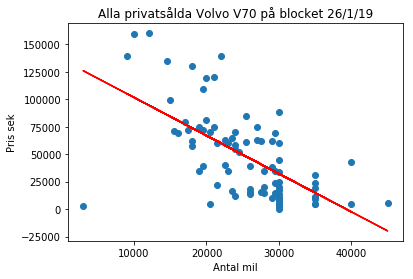

In [30]:
fig, ax = plt.subplots()
plt.scatter = ax.scatter(x = 'from', y = 'price', data = v70)
plt.plot(v70['from'], b + m * v70['from'], '-', c = 'r')
plt.xlabel('Antal mil')
plt.ylabel('Pris sek')
plt.title('Alla privatsålda Volvo V70 på blocket 26/1/19')
plt.show()

### Part 3
#### Feb 2, 2019

We want to keep clean the data and make some feature engineering. We want to make a regression model to predict prices based on the scraped data. And when new data is scraped we can find the (according to the model) most undervalued cars. One problem is that the best priced cars will get bought first so our scraped training data is consisting of cars that has been for a sale for a while and might not be priced as well as the ones that imedately gets sold. The model will probably therefore favor cars that recently has been added. To go around this problem scraping should continously be done so that the model could be built on all cars posted on Blocket and not on a sample where the majority of the cars have been for sale a long time.

In [31]:
import seaborn as sns

Tyring out a nice looking plot with seaborn.

C:\Users\jonas\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


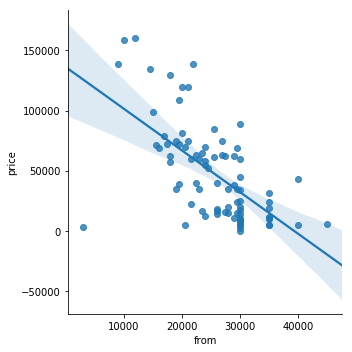

In [32]:
sns.lmplot(x = 'from', y = 'price', data = v70)
plt.show()

We will create a new feature called `time_since_listing` equal to the current time - `date`.

In [33]:
from time import gmtime, strftime
current_time = strftime("%Y-%m-%d %H:%M:%S", gmtime())
current_time

'2019-05-10 04:04:37'

Make sure the dates are on same form.

In [34]:
df[["date"]].collect()[0][0]

'2019-03-21 21:46:37'

Add the current time as a constant column to the data farme.

In [35]:
import pyspark.sql.functions as F
df = df.withColumn("current_time", F.lit(current_time))
df[["current_time"]].show(2)

+-------------------+
|       current_time|
+-------------------+
|2019-05-10 04:04:37|
|2019-05-10 04:04:37|
+-------------------+
only showing top 2 rows



Subtracting the listing time from the current time and stores is in a colum `time_since_listing` and drop the constant colum `current_time` from the data frame.

In [36]:
timeFmt = "yyyy-MM-dd HH:mm:ss"
timeDiff = (F.unix_timestamp('current_time', format=timeFmt) - F.unix_timestamp('date', format=timeFmt))

df = df.withColumn("time_since_listing", timeDiff)
df = df.drop("current_time")
df[["time_since_listing"]].show(5)

+------------------+
|time_since_listing|
+------------------+
|           4256280|
|           4256302|
|           4256322|
|           4256351|
|           4256385|
+------------------+
only showing top 5 rows



We also want to check out the distribution of days on which cars get upploaded. We create a column `Day_of_week`.

In [37]:
df = df.withColumn("Day_of_week", F.dayofweek(df["date"]))
df[["Day_of_week"]].show(5)

+-----------+
|Day_of_week|
+-----------+
|          5|
|          5|
|          5|
|          5|
|          5|
+-----------+
only showing top 5 rows



Convert to pandas for plotting and plot.

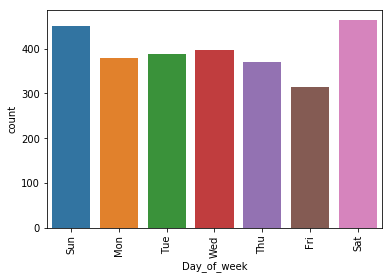

In [38]:
pandas_df = df.toPandas()

ax = sns.countplot(x="Day_of_week", data = pandas_df)
ax.set_xticklabels(["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"], rotation='vertical', fontsize=10)
plt.show()

In [39]:
pandas_df

,date,title,dist,price,fuel,gear,location,from,to,brand,model,time_since_listing,Day_of_week
0,2019-03-21 21:46:37,cadillac deville cab 1969,3 500 - 3 999,229000.0,Bensin,Automat,Ystad,3500.0,3999.0,cadillac,deville,4256280,5
1,2019-03-21 21:46:15,peugeot 206 1.4 -05,10 500 - 10 999,26000.0,Bensin,Manuell,Höör,10500.0,10999.0,peugeot,206,4256302,5
2,2019-03-21 21:45:55,audi a3 1|6 l -05,23 000 - 23 499,29000.0,Bensin,Manuell,Sydväst,23000.0,23499.0,audi,a3,4256322,5
3,2019-03-21 21:45:26,seat ateca tsi 150 dsg xcellence överlåtelse -17,2 500 - 2 999,225000.0,Bensin,Automat,Helsingborg,2500.0,2999.0,seat,ateca,4256351,5
4,2019-03-21 21:44:52,volvo xc70 2.5t -05,27 000 - 27 499,28000.0,Bensin,Manuell,Sjöbo,27000.0,27499.0,volvo,xc70,4256385,5
5,2019-03-21 21:43:38,peugeot 307 xr 1.6 nybesiktigad & nyservad -02,17 500 - 17 999,16000.0,Bensin,Manuell,Helsingborg,17500.0,17999.0,peugeot,307,4256459,5
6,2019-03-21 21:42:29,citroen c1 -08,5 000 - 5 499,29500.0,Bensin,Manuell,Helsingborg,5000.0,5499.0,citroen,c1,4256528,5
7,2019-03-21 21:42:27,bmw 330 i touring 258hk -06,17 500 - 17 999,79500.0,Bensin,Automat,Båstad,17500.0,17999.0,bmw,330,4256530,5
8,2019-03-21 21:41:45,golf 5 1.9 tdi -05,28 000 - 28 499,35900.0,Diesel,Manuell,Östra Göinge,28000.0,28499.0,golf,5,4256572,5
9,2019-03-21 21:20:09,saab 9-5 sportkombi 2|3t 185hk -03,30 000 - 34 999,8000.0,Bensin,Manuell,Lund,30000.0,34999.0,saab,9-5,4257868,5


In [40]:
df.groupBy("fuel").count().show()

+-------------------+-----+
|               fuel|count|
+-------------------+-----+
|             Bensin| 1740|
|             Diesel|  957|
|Miljöbränsle/Hybrid|   60|
|                 El|    6|
+-------------------+-----+



In [41]:
df.groupBy("gear").count().show()

+-------+-----+
|   gear|count|
+-------+-----+
|Manuell| 1795|
|Automat|  968|
+-------+-----+



In [42]:
df.groupBy("location").count().show()

+------------+-----+
|    location|count|
+------------+-----+
|     Klippan|   47|
|        Lund|  143|
|       Lomma|   36|
|  Hässleholm|  155|
|      Sydost|   73|
|      Skurup|   38|
|   Tomelilla|   39|
|    Kävlinge|   43|
|     Svedala|   42|
|Kristianstad|  225|
|Östra Göinge|   30|
|       Hörby|   52|
|      Båstad|   22|
|      Burlöv|   52|
|    Perstorp|   17|
|  Trelleborg|  116|
|       Sjöbo|   36|
|     Höganäs|   52|
|    Bromölla|   19|
|  Landskrona|   95|
+------------+-----+
only showing top 20 rows



End of session Feb 02, 2019.